In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  LabelEncoder

In [35]:
!pip install pycaret

  Using cached pycaret-3.0.4-py3-none-any.whl (484 kB)
  Using cached yellowbrick-1.5-py3-none-any.whl (282 kB)
  Using cached tbats-1.1.3-py3-none-any.whl (44 kB)
  Using cached pyod-1.1.0-py3-none-any.whl
  Using cached sktime-0.20.1-py3-none-any.whl (17.1 MB)
  Using cached scikit_plot-0.3.7-py3-none-any.whl (33 kB)
  Using cached deprecation-2.1.0-py2.py3-none-any.whl (11 kB)
  Using cached joblib-1.3.1-py3-none-any.whl (301 kB)
  Using cached pmdarima-2.0.3-cp310-cp310-win_amd64.whl (569 kB)
  Using cached plotly_resampler-0.9.1-py3-none-any.whl (73 kB)
  Using cached category_encoders-2.6.1-py2.py3-none-any.whl (81 kB)
  Using cached importlib_metadata-6.8.0-py3-none-any.whl (22 kB)
  Using cached tsdownsample-0.1.2-cp310-none-win_amd64.whl (1.0 MB)
  Using cached dash-2.11.1-py3-none-any.whl (10.4 MB)
  Using cached Cython-3.0.0-cp310-cp310-win_amd64.whl (2.8 MB)
  Using cached Deprecated-1.2.14-py2.py3-none-any.whl (9.6 kB)
  Using cached ansi2html-1.8.0-py3-none-any.whl (16 kB

<h3>Загрузка и предобработка датасета</h3>

In [3]:
#загрузка датасета
df = pd.read_csv('coords_data_numerated.csv')
df = df.drop(columns=['Unnamed: 0', 'GSR'])
df.head()

,id,BreathingType,TimeStamp_sec,FirstMarkerXCoord,FirstMarkerYCoord,FirstMarkerZCoord,SecondMarkerXCoord,SecondMarkerYCoord,SecondMarkerZCoord,ThirdMarkerXCoord,ThirdMarkerYCoord,ThirdMarkerZCoord
0,1,0,0.058895,0.689,-1.453,4.417,0.881,-1.544,4.547,0.718,-1.607,4.369
1,1,0,0.111889,0.687,-1.452,4.418,0.881,-1.544,4.547,0.715,-1.607,4.371
2,1,0,0.158371,0.687,-1.451,4.419,0.881,-1.544,4.545,0.714,-1.607,4.371
3,1,0,0.262516,0.685,-1.450,4.420,0.882,-1.544,4.541,0.711,-1.608,4.373
4,1,0,0.295620,0.684,-1.449,4.420,0.883,-1.544,4.540,0.709,-1.607,4.370


In [4]:
#Определение выходного признака и входных признаков
y = df['BreathingType']
X = df.drop(columns=['BreathingType'])
X.tail()

,id,TimeStamp_sec,FirstMarkerXCoord,FirstMarkerYCoord,FirstMarkerZCoord,SecondMarkerXCoord,SecondMarkerYCoord,SecondMarkerZCoord,ThirdMarkerXCoord,ThirdMarkerYCoord,ThirdMarkerZCoord
230921,258,59.76925,1.063,-1.649,3.843,1.093,-1.839,3.624,1.030,-1.867,3.859
230922,258,59.80188,1.062,-1.648,3.842,1.094,-1.841,3.625,1.030,-1.867,3.857
230923,258,59.90696,1.062,-1.648,3.842,1.093,-1.841,3.624,1.030,-1.868,3.855
230924,258,59.92954,1.063,-1.647,3.842,1.094,-1.841,3.624,1.029,-1.868,3.853
230925,258,59.99477,1.063,-1.647,3.842,1.094,-1.841,3.623,1.030,-1.868,3.853


In [5]:
#переименование столбцов
dict_renames = {
    'FirstMarkerXCoord' : 'FMX',
    'FirstMarkerYCoord' : 'FMY',
    'FirstMarkerZCoord' : 'FMZ',
    'SecondMarkerXCoord' :  'SMX',
    'SecondMarkerYCoord' : 'SMY',
    'SecondMarkerZCoord' : 'SMZ',
    'ThirdMarkerXCoord' : 'TMX',
    'ThirdMarkerYCoord' : 'TMY',
    'ThirdMarkerZCoord' : 'TMZ'
}
X = X.rename(columns=dict_renames)
X.head()

,id,TimeStamp_sec,FMX,FMY,FMZ,SMX,SMY,SMZ,TMX,TMY,TMZ
0,1,0.058895,0.689,-1.453,4.417,0.881,-1.544,4.547,0.718,-1.607,4.369
1,1,0.111889,0.687,-1.452,4.418,0.881,-1.544,4.547,0.715,-1.607,4.371
2,1,0.158371,0.687,-1.451,4.419,0.881,-1.544,4.545,0.714,-1.607,4.371
3,1,0.262516,0.685,-1.450,4.420,0.882,-1.544,4.541,0.711,-1.608,4.373
4,1,0.295620,0.684,-1.449,4.420,0.883,-1.544,4.540,0.709,-1.607,4.370


<h3>Извлечение признаков с помощью библиотеки TSFresh</h3>

In [6]:
import tsfresh

In [7]:
settings = tsfresh.feature_extraction.settings.ComprehensiveFCParameters()

In [8]:
extracted_features = tsfresh.extract_features(X, column_sort='TimeStamp_sec', column_id='id', default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 30/30 [06:33<00:00, 13.11s/it]


In [9]:
extracted_features.head()

,SMX__variance_larger_than_standard_deviation,SMX__has_duplicate_max,SMX__has_duplicate_min,SMX__has_duplicate,SMX__sum_values,SMX__abs_energy,SMX__mean_abs_change,SMX__mean_change,SMX__mean_second_derivative_central,SMX__median,...,FMZ__fourier_entropy__bins_5,FMZ__fourier_entropy__bins_10,FMZ__fourier_entropy__bins_100,FMZ__permutation_entropy__dimension_3__tau_1,FMZ__permutation_entropy__dimension_4__tau_1,FMZ__permutation_entropy__dimension_5__tau_1,FMZ__permutation_entropy__dimension_6__tau_1,FMZ__permutation_entropy__dimension_7__tau_1,FMZ__query_similarity_count__query_None__threshold_0.0,FMZ__mean_n_absolute_max__number_of_maxima_7
1,0.0,1.0,1.0,1.0,786.339,686.379751,0.000353,-0.000004,0.000000e+00,0.875,...,0.204871,0.367289,0.929162,1.472701,2.419640,3.438875,4.449709,5.273135,NaN,4.435429
2,0.0,1.0,1.0,1.0,802.607,715.117611,0.000334,-0.000041,-5.561735e-07,0.891,...,0.183378,0.310337,0.842774,1.562161,2.638883,3.795032,4.872082,5.708663,NaN,4.417429
3,0.0,0.0,1.0,1.0,773.539,664.234557,0.000439,-0.000026,-5.561735e-07,0.856,...,0.136002,0.215617,0.758199,1.515849,2.540378,3.625466,4.631890,5.442175,NaN,4.445286
4,0.0,1.0,1.0,1.0,894.241,887.645061,0.000349,-0.000007,-1.112347e-06,0.995,...,0.090729,0.090729,0.442198,1.338456,2.129546,2.938742,3.717525,4.405405,NaN,4.298143
5,0.0,1.0,1.0,1.0,749.086,622.802878,0.000310,0.000014,0.000000e+00,0.831,...,0.249958,0.433549,1.201067,1.343022,2.175330,3.074689,4.002324,4.823140,NaN,4.238000


In [10]:
unique_pairs = df[['id', 'BreathingType']].drop_duplicates()
unique_pairs = unique_pairs.reset_index(drop=True)
y = unique_pairs
y.index = y['id']
y = y.drop(columns=['id'])
y = pd.Series(y['BreathingType'])

In [11]:
y

id
1      0
2      1
3      2
4      0
5      1
      ..
254    1
255    2
256    0
257    1
258    2
Name: BreathingType, Length: 258, dtype: int64

In [12]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features)
features_filtered = select_features(extracted_features, y, multiclass=True)

C:\Users\Student\anaconda3\lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['SMX__query_similarity_count__query_None__threshold_0.0'
 'SMY__friedrich_coefficients__coeff_0__m_3__r_30'
 'SMY__friedrich_coefficients__coeff_1__m_3__r_30'
 'SMY__friedrich_coefficients__coeff_2__m_3__r_30'
 'SMY__friedrich_coefficients__coeff_3__m_3__r_30'
 'SMY__max_langevin_fixed_point__m_3__r_30'
 'SMY__query_similarity_count__query_None__threshold_0.0'
 'SMZ__query_similarity_count__query_None__threshold_0.0'
 'TMX__query_similarity_count__query_None__threshold_0.0'
 'TMY__query_similarity_count__query_None__threshold_0.0'
 'TMZ__query_similarity_count__query_None__threshold_0.0'
 'FMX__query_similarity_count__query_None__threshold_0.0'
 'FMY__query_similarity_count__query_None__threshold_0.0'
 'FMZ__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


In [13]:
features_filtered.head()

,"FMY__agg_autocorrelation__f_agg_""var""__maxlag_40","FMY__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""var""",FMY__partial_autocorrelation__lag_3,FMY__fourier_entropy__bins_10,"FMY__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","FMY__linear_trend__attr_""stderr""","FMY__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","FMY__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","FMY__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""","FMY__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""",...,"FMZ__fft_coefficient__attr_""real""__coeff_37","TMX__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","TMX__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""","TMX__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""var""","TMX__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.8","TMX__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""var""","TMX__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.8","TMX__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8","TMX__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""var""",TMX__ar_coefficient__coeff_1__k_10
1,0.203342,0.000013,-0.222898,0.136002,0.000012,4.290971e-07,0.000005,0.000005,0.000005,0.000013,...,0.156939,0.000045,1.293342e-06,2.114180e-08,0.000635,2.229450e-09,9.175544e-07,5.300205e-07,1.498184e-06,1.075671
2,0.368654,0.000055,-0.325654,0.136002,0.000031,1.024434e-06,0.000011,0.000011,0.000011,0.000032,...,0.109409,0.000028,3.231085e-07,8.509713e-09,0.000358,7.471823e-10,3.678488e-07,2.400601e-07,7.830371e-07,0.936582
3,0.368037,0.000052,-0.381678,0.136002,0.000035,1.141785e-06,0.000013,0.000013,0.000013,0.000034,...,0.180152,0.000055,1.314077e-06,2.155637e-08,0.000715,2.006410e-09,1.060953e-06,5.501077e-07,2.354984e-06,0.937611
4,0.029265,0.000003,-0.126742,0.280179,0.000009,2.894390e-07,0.000003,0.000003,0.000003,0.000009,...,0.124672,0.000036,7.638346e-07,1.435572e-08,0.000398,1.644779e-09,4.077468e-07,2.497918e-07,7.360300e-07,1.090171
5,0.254175,0.000007,-0.265776,0.170467,0.000010,3.465600e-07,0.000004,0.000004,0.000004,0.000011,...,0.123733,0.000014,2.256864e-07,2.989264e-09,0.000254,3.413762e-10,2.613493e-07,1.969553e-07,1.301934e-07,0.831451


In [14]:
features_filtered.to_csv('features_filtered.csv')

In [7]:
new_features = features_filtered.reset_index()

<h3>Добавление новых признаков в датасет</h3>

In [4]:
features_filtered = pd.read_csv('features_filtered.csv')
features_filtered = features_filtered.drop(columns=['Unnamed: 0'])
features_filtered.head()

,"FMY__agg_autocorrelation__f_agg_""var""__maxlag_40","FMY__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""var""",FMY__partial_autocorrelation__lag_3,FMY__fourier_entropy__bins_10,"FMY__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","FMY__linear_trend__attr_""stderr""","FMY__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","FMY__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","FMY__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""","FMY__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""",...,"FMZ__fft_coefficient__attr_""real""__coeff_37","TMX__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","TMX__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""","TMX__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""var""","TMX__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.8","TMX__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""var""","TMX__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.8","TMX__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8","TMX__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""var""",TMX__ar_coefficient__coeff_1__k_10
0,0.203342,0.000013,-0.222898,0.136002,0.000012,4.290971e-07,0.000005,0.000005,0.000005,0.000013,...,0.156939,0.000045,1.293342e-06,2.114180e-08,0.000635,2.229450e-09,9.175544e-07,5.300205e-07,1.498184e-06,1.075671
1,0.368654,0.000055,-0.325654,0.136002,0.000031,1.024434e-06,0.000011,0.000011,0.000011,0.000032,...,0.109409,0.000028,3.231085e-07,8.509713e-09,0.000358,7.471823e-10,3.678488e-07,2.400601e-07,7.830371e-07,0.936582
2,0.368037,0.000052,-0.381678,0.136002,0.000035,1.141785e-06,0.000013,0.000013,0.000013,0.000034,...,0.180152,0.000055,1.314077e-06,2.155637e-08,0.000715,2.006410e-09,1.060953e-06,5.501077e-07,2.354984e-06,0.937611
3,0.029265,0.000003,-0.126742,0.280179,0.000009,2.894390e-07,0.000003,0.000003,0.000003,0.000009,...,0.124672,0.000036,7.638346e-07,1.435572e-08,0.000398,1.644779e-09,4.077468e-07,2.497918e-07,7.360300e-07,1.090171
4,0.254175,0.000007,-0.265776,0.170467,0.000010,3.465600e-07,0.000004,0.000004,0.000004,0.000011,...,0.123733,0.000014,2.256864e-07,2.989264e-09,0.000254,3.413762e-10,2.613493e-07,1.969553e-07,1.301934e-07,0.831451


In [5]:
#загрузка датасета
data = pd.read_csv('breathes.csv')
data = data.drop(columns=['Unnamed: 0'])
data.head()

,ID,Date_Of_Birth,Sex,Had_Covid,Begin_Of_Covid,End_Of_Covid,Lung_Damage,Damage_Percent,Breathing_Type,Frequency,...,Sin_Period23,Sin_Amp23/Sin_Amp13,Sin_Amp12/Sin_Amp13,Sin_Amp12/Sin_Amp23,Sin_Omega23/Sin_Omega13,Sin_Omega12/Sin_Omega13,Sin_Omega12/Sin_Omega23,(Sin_Offset23/Sin_Offset13)^2,(Sin_Offset12/Sin_Offset13)^2,(Sin_Offset12/Sin_Offset23)^2
0,1,04.07.2003,M,No,00.00.0000,00.00.0000,No,-0.207005,грудное,-0.144237,...,-0.178712,0.002273,-0.001832,-0.032392,-0.156378,-0.155622,-0.156309,-0.088206,-0.063808,-0.059907
1,1,04.07.2003,M,No,00.00.0000,00.00.0000,No,-0.207005,брюшное,-0.464100,...,-0.189949,0.004160,-0.001251,-0.031075,-0.157239,-0.156233,-0.155913,-0.088137,-0.063796,-0.059920
2,1,04.07.2003,M,No,00.00.0000,00.00.0000,No,-0.207005,смешанное,-1.423688,...,-0.176731,0.002901,-0.001624,-0.030850,-0.156010,-0.154825,-0.155960,-0.088171,-0.063814,-0.059919
3,2,07.09.2001,M,No,00.00.0000,00.00.0000,No,-0.207005,грудное,-0.464100,...,-0.188340,0.001370,-0.003038,-0.030842,-0.150565,-0.157859,-0.162806,-0.088344,-0.063916,-0.059910
4,2,07.09.2001,M,No,00.00.0000,00.00.0000,No,-0.207005,брюшное,-0.464100,...,-0.183617,0.009269,-0.003303,-0.031408,-0.166810,-0.156948,-0.130142,-0.088307,-0.063910,-0.059921


In [8]:
#добавление новых признаков в датасет
i = 0
new_features_cols = new_features.columns
for id in range(1,87):
    print(id)
    for col in new_features_cols:
        data.loc[(data['Breathing_Type'] == 'грудное') & (data['ID'] == id), col]= new_features.loc[i][col]
    i += 1
    for col in new_features_cols:
        data.loc[(data['Breathing_Type'] == 'брюшное') & (data['ID'] == id), col] = new_features.loc[i][col]
    i += 1
    for col in new_features_cols:
        data.loc[(data['Breathing_Type'] == 'смешанное') & (data['ID'] == id), col] = new_features.loc[i][col]
    i += 1

1


C:\Users\Student\AppData\Local\Temp\ipykernel_13440\4067364104.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[(data['Breathing_Type'] == 'грудное') & (data['ID'] == id), col]= new_features.loc[i][col]
C:\Users\Student\AppData\Local\Temp\ipykernel_13440\4067364104.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[(data['Breathing_Type'] == 'грудное') & (data['ID'] == id), col]= new_features.loc[i][col]
C:\Users\Student\AppData\Local\Temp\ipykernel_13440\4067364104.py:7: PerformanceWarning: DataFrame is hi

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86


In [9]:
data.head(15)

,ID,Date_Of_Birth,Sex,Had_Covid,Begin_Of_Covid,End_Of_Covid,Lung_Damage,Damage_Percent,Breathing_Type,Frequency,...,"FMZ__fft_coefficient__attr_""real""__coeff_37","TMX__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","TMX__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""var""","TMX__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""var""","TMX__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.8","TMX__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""var""","TMX__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.8","TMX__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8","TMX__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""var""",TMX__ar_coefficient__coeff_1__k_10
0,1,04.07.2003,M,No,00.00.0000,00.00.0000,No,-0.207005,грудное,-0.144237,...,0.156939,0.000045,1.293342e-06,2.114180e-08,0.000635,2.229450e-09,9.175544e-07,5.300205e-07,1.498184e-06,1.075671
1,1,04.07.2003,M,No,00.00.0000,00.00.0000,No,-0.207005,брюшное,-0.464100,...,0.109409,0.000028,3.231085e-07,8.509713e-09,0.000358,7.471823e-10,3.678488e-07,2.400601e-07,7.830371e-07,0.936582
2,1,04.07.2003,M,No,00.00.0000,00.00.0000,No,-0.207005,смешанное,-1.423688,...,0.180152,0.000055,1.314077e-06,2.155637e-08,0.000715,2.006410e-09,1.060953e-06,5.501077e-07,2.354984e-06,0.937611
3,2,07.09.2001,M,No,00.00.0000,00.00.0000,No,-0.207005,грудное,-0.464100,...,0.124672,0.000036,7.638346e-07,1.435572e-08,0.000398,1.644779e-09,4.077468e-07,2.497918e-07,7.360300e-07,1.090171
4,2,07.09.2001,M,No,00.00.0000,00.00.0000,No,-0.207005,брюшное,-0.464100,...,0.123733,0.000014,2.256864e-07,2.989264e-09,0.000254,3.413762e-10,2.613493e-07,1.969553e-07,1.301934e-07,0.831451
5,2,07.09.2001,M,No,00.00.0000,00.00.0000,No,-0.207005,смешанное,-0.464100,...,-0.089632,0.000028,7.293849e-07,1.069506e-08,0.000415,1.427669e-09,4.715586e-07,2.995545e-07,6.361164e-07,1.055691
6,3,14.04.2003,M,No,00.00.0000,00.00.0000,No,-0.207005,грудное,2.734525,...,-0.500295,0.000027,1.639148e-07,1.366298e-08,0.000442,1.325287e-09,5.327630e-07,3.379628e-07,5.302871e-07,0.933156
7,3,14.04.2003,M,No,00.00.0000,00.00.0000,No,-0.207005,брюшное,-0.144237,...,0.056027,0.000020,2.611713e-07,3.933847e-09,0.000271,4.894769e-10,2.803738e-07,2.069176e-07,2.551207e-07,0.909929
8,3,14.04.2003,M,No,00.00.0000,00.00.0000,No,-0.207005,смешанное,-0.624031,...,0.029082,0.000047,1.177089e-06,3.161414e-08,0.000754,3.556844e-09,1.184249e-06,6.239812e-07,2.195248e-06,1.111093
9,4,24.11.2003,M,Yes,05.11.2021,19.11.2021,No,-0.207005,грудное,-0.304169,...,-0.210705,0.000018,2.568889e-07,8.310353e-09,0.000377,9.685907e-10,4.112980e-07,2.691918e-07,4.700725e-07,0.881412


<h3>Подготовка датасета для тестирования</h3>

In [10]:
#отбрасывание ненужных столбцов
categorical_cols = ['Sex', 'Had_Covid', 'Lung_Damage', 'DominatorFreq']
drop_columns = ['Date_Of_Birth', 'Begin_Of_Covid', 'End_Of_Covid'] + categorical_cols
df = data.drop(columns=drop_columns)
#целевой признак
y = df['Breathing_Type']
#определение численных признаков
non_numerical_cols = ['ID', 'Breathing_Type']
X = df.drop(columns=non_numerical_cols)
#трансформация категориальных признаков
le = LabelEncoder()
y = le.fit_transform(y)

In [11]:
#разделение на обучающую(70%) и тестовую (30%) выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
from sklearn.metrics import recall_score, accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
#расчет метрик по тесовой выборке
def calculate_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Accuracy: ", accuracy)
    print("Recall: ", recall)
    print("Precision: ", precision)
    print("F1-score: ", f1)
    report = classification_report(y_test, y_pred)
    print(report)

#расчет знамости признаков
def calc_feature_importances(model, X_df):
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({'Feature': X_df.columns, 'Importance': importance})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    return feature_importance

<h2>Тестирование новых признаков</h2>

<h3>Generic Univariate Select (Mutual Info)</h3>

In [13]:
from sklearn.feature_selection import mutual_info_classif, GenericUnivariateSelect
selector = GenericUnivariateSelect(mutual_info_classif, mode='k_best', param=50)

In [14]:
X_new = selector.fit_transform(X, y)

In [15]:
importance = selector.scores_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Scores': importance, 'Support': selector.get_support()})
feature_importance = feature_importance.sort_values('Scores', ascending=False)
feature_importance

,Feature,Scores,Support
38,"FMY__agg_linear_trend__attr_""stderr""__chunk_le...",0.169269,True
40,"FMY__agg_linear_trend__attr_""stderr""__chunk_le...",0.167855,True
108,"FMY__change_quantiles__f_agg_""mean""__isabs_Tru...",0.166709,True
35,"FMY__agg_linear_trend__attr_""intercept""__chunk...",0.159426,True
184,"TMX__change_quantiles__f_agg_""var""__isabs_Fals...",0.159004,True
...,...,...,...
229,"SMX__change_quantiles__f_agg_""var""__isabs_Fals...",0.000000,False
1,Frequency,0.000000,False
17,Sin_Period13,0.000000,False
219,"SMX__change_quantiles__f_agg_""var""__isabs_True...",0.000000,False


In [28]:
feature_importance.to_excel('mutual_features.xlsx')

In [16]:
bad_features = feature_importance[feature_importance['Support'] == False]
bad_features['Feature'].to_list()

['SMZ__linear_trend__attr_"pvalue"',
 'FMY__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"',
 'FMY__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"',
 'TMX__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"var"',
 'FMY__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2',
 'FMY__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4',
 'TMX__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"',
 'TMX__change_quantiles__f_agg_"var"__isabs_False__qh_0.8__ql_0.2',
 'TMX__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2',
 'FMY__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.2',
 'FMY__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4',
 'TMX__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"var"',
 'FMY__sum_of_reoccurring_values',
 'FMY__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.4',
 'FMY__partial_autocorrelation__lag_3',
 'TMX__fft_coefficient__attr_"abs"__coeff_33',
 'FMY__fourier_ent

In [17]:
df_new = df.drop(columns = bad_features['Feature'].to_list())
df_new.head()

,ID,Breathing_Type,Sin_Amp12,Sin_Amp12/Sin_Amp23,Sin_Omega12/Sin_Omega23,"FMY__agg_autocorrelation__f_agg_""var""__maxlag_40","FMY__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""var""","FMY__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","FMY__linear_trend__attr_""stderr""","FMY__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""",...,"TMX__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.0","TMX__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.0","TMX__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6","TMX__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.4","TMX__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","TMX__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.6","TMX__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.6","TMX__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","TMX__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.8",TMX__ar_coefficient__coeff_1__k_10
0,1,грудное,-0.034874,-0.032392,-0.156309,0.203342,0.000013,0.000012,4.290971e-07,0.000005,...,6.763855e-07,6.806536e-07,4.229679e-07,8.473183e-07,4.632218e-07,8.984511e-07,4.951089e-07,0.000016,0.000635,1.075671
1,1,брюшное,-0.034173,-0.031075,-0.155913,0.368654,0.000055,0.000031,1.024434e-06,0.000011,...,4.478439e-07,4.418068e-07,1.996786e-07,3.911713e-07,2.549399e-07,3.330646e-07,2.258353e-07,0.000010,0.000358,0.936582
2,1,смешанное,-0.035428,-0.030850,-0.155960,0.368037,0.000052,0.000035,1.141785e-06,0.000013,...,6.338819e-07,6.509860e-07,4.746822e-07,9.371381e-07,4.682391e-07,1.042469e-06,5.147840e-07,0.000019,0.000715,0.937611
3,2,грудное,-0.034864,-0.030842,-0.162806,0.029265,0.000003,0.000009,2.894390e-07,0.000003,...,6.729151e-07,7.188767e-07,3.164530e-07,5.973936e-07,3.391330e-07,4.952294e-07,2.898850e-07,0.000013,0.000398,1.090171
4,2,брюшное,-0.034066,-0.031408,-0.130142,0.254175,0.000007,0.000010,3.465600e-07,0.000004,...,2.519664e-07,2.394046e-07,1.306342e-07,2.460533e-07,1.872313e-07,2.487646e-07,1.892422e-07,0.000005,0.000254,0.831451


In [18]:
df_new = df_new.drop(columns=['ID'])
df_new.head()

,Breathing_Type,Sin_Amp12,Sin_Amp12/Sin_Amp23,Sin_Omega12/Sin_Omega23,"FMY__agg_autocorrelation__f_agg_""var""__maxlag_40","FMY__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""var""","FMY__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","FMY__linear_trend__attr_""stderr""","FMY__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","FMY__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""",...,"TMX__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.0","TMX__change_quantiles__f_agg_""var""__isabs_False__qh_0.6__ql_0.0","TMX__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.6","TMX__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.4","TMX__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","TMX__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.6","TMX__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.6","TMX__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""","TMX__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.8",TMX__ar_coefficient__coeff_1__k_10
0,грудное,-0.034874,-0.032392,-0.156309,0.203342,0.000013,0.000012,4.290971e-07,0.000005,0.000005,...,6.763855e-07,6.806536e-07,4.229679e-07,8.473183e-07,4.632218e-07,8.984511e-07,4.951089e-07,0.000016,0.000635,1.075671
1,брюшное,-0.034173,-0.031075,-0.155913,0.368654,0.000055,0.000031,1.024434e-06,0.000011,0.000011,...,4.478439e-07,4.418068e-07,1.996786e-07,3.911713e-07,2.549399e-07,3.330646e-07,2.258353e-07,0.000010,0.000358,0.936582
2,смешанное,-0.035428,-0.030850,-0.155960,0.368037,0.000052,0.000035,1.141785e-06,0.000013,0.000013,...,6.338819e-07,6.509860e-07,4.746822e-07,9.371381e-07,4.682391e-07,1.042469e-06,5.147840e-07,0.000019,0.000715,0.937611
3,грудное,-0.034864,-0.030842,-0.162806,0.029265,0.000003,0.000009,2.894390e-07,0.000003,0.000003,...,6.729151e-07,7.188767e-07,3.164530e-07,5.973936e-07,3.391330e-07,4.952294e-07,2.898850e-07,0.000013,0.000398,1.090171
4,брюшное,-0.034066,-0.031408,-0.130142,0.254175,0.000007,0.000010,3.465600e-07,0.000004,0.000004,...,2.519664e-07,2.394046e-07,1.306342e-07,2.460533e-07,1.872313e-07,2.487646e-07,1.892422e-07,0.000005,0.000254,0.831451


<h3>Автопобор модели и гиперпараметров с помощью PyCaret</h3>

In [29]:
from pycaret.classification import *

In [30]:
exp = ClassificationExperiment()

In [31]:
exp.setup(df_new, target = 'Breathing_Type', session_id = 124)

,Description,Value
0,Session id,124
1,Target,Breathing_Type
2,Target type,Multiclass
3,Target mapping,"брюшное: 0, грудное: 1, смешанное: 2"
4,Original data shape,"(251, 51)"
5,Transformed data shape,"(251, 51)"
6,Transformed train set shape,"(175, 51)"
7,Transformed test set shape,"(76, 51)"
8,Numeric features,50
9,Preprocess,True


In [32]:
best = exp.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7408,0.8703,0.7408,0.7673,0.7393,0.6107,0.6214,0.0780
lightgbm,Light Gradient Boosting Machine,0.7245,0.8695,0.7245,0.7403,0.7182,0.5867,0.5972,0.0720
xgboost,Extreme Gradient Boosting,0.7075,0.8669,0.7075,0.7260,0.7012,0.5617,0.5725,0.0610
rf,Random Forest Classifier,0.6556,0.8296,0.6556,0.6664,0.6466,0.4851,0.4966,0.0720
et,Extra Trees Classifier,0.6105,0.7967,0.6105,0.6106,0.6001,0.4159,0.4231,0.0710
ridge,Ridge Classifier,0.6052,0.0000,0.6052,0.6137,0.5930,0.4084,0.4196,0.0370
ada,Ada Boost Classifier,0.6003,0.7281,0.6003,0.6227,0.5910,0.4010,0.4139,0.0540
lr,Logistic Regression,0.5869,0.7506,0.5869,0.5889,0.5764,0.3820,0.3886,0.0480
dt,Decision Tree Classifier,0.5647,0.6750,0.5647,0.5923,0.5632,0.3487,0.3585,0.0410
svm,SVM - Linear Kernel,0.5369,0.0000,0.5369,0.5552,0.4998,0.3050,0.3302,0.0400


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [52]:
exp.plot_model(best, plot='parameter')

,Parameters
ccp_alpha,0.0
criterion,friedman_mse
init,None
learning_rate,0.1
loss,log_loss
max_depth,3
max_features,None
max_leaf_nodes,None
min_impurity_decrease,0.0
min_samples_leaf,1


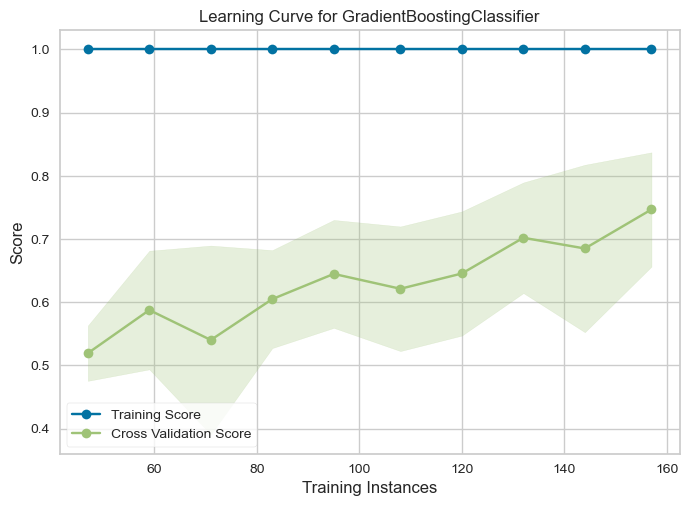

In [50]:
exp.plot_model(best, plot='learning')

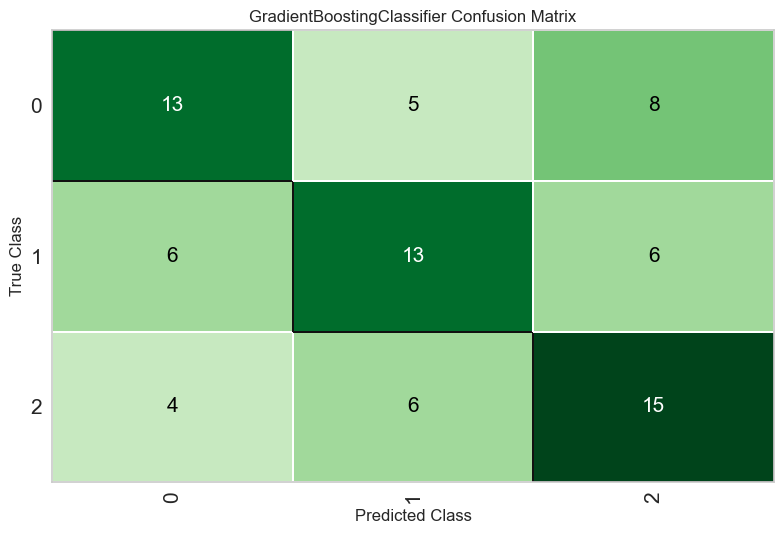

In [42]:
exp.plot_model(best, plot='confusion_matrix')

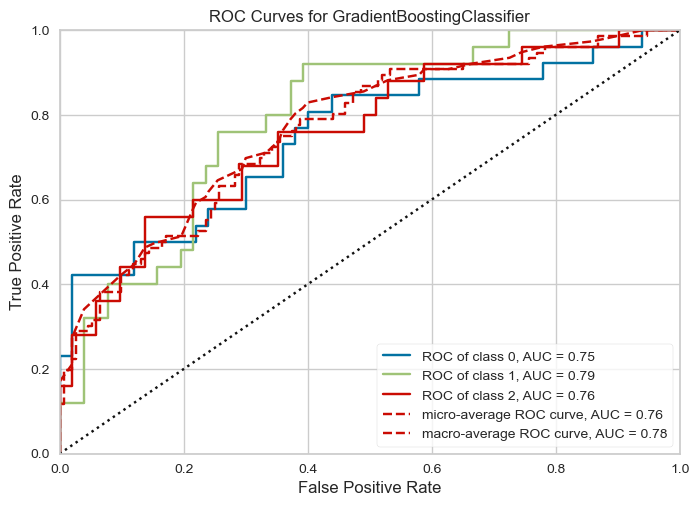

In [43]:
exp.plot_model(best, plot='auc')

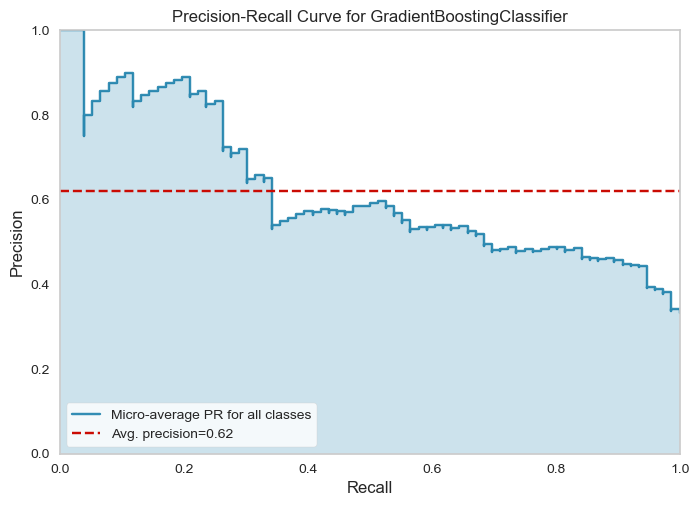

In [45]:
exp.plot_model(best, plot='pr')

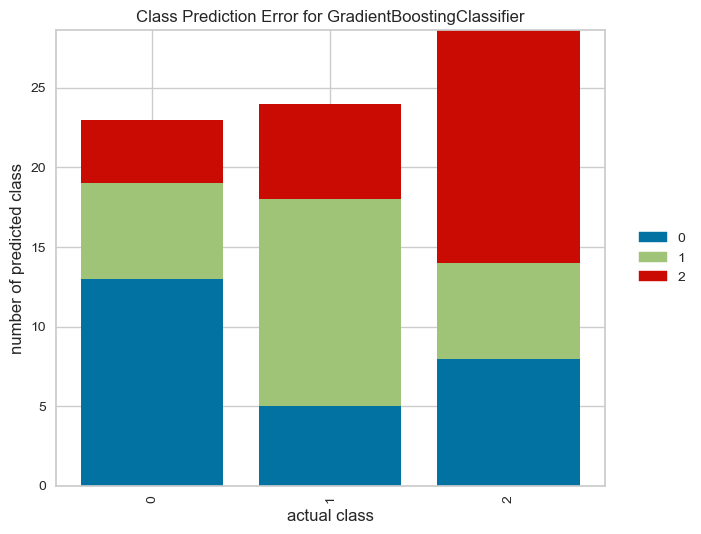

In [46]:
exp.plot_model(best, plot='error')

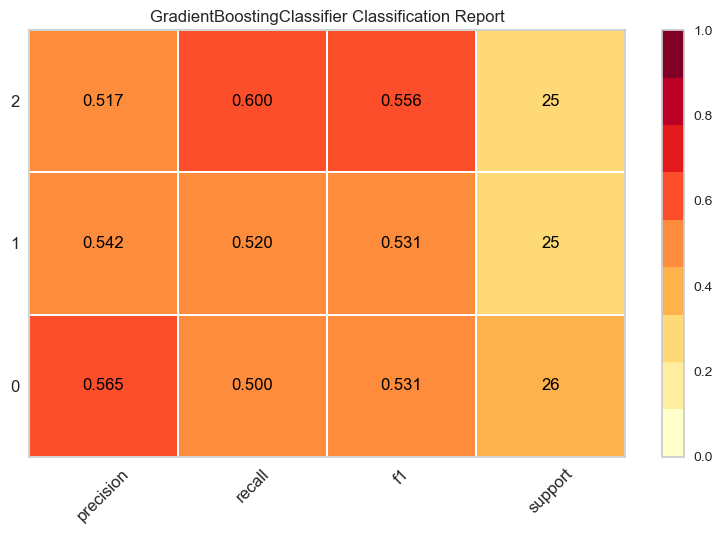

In [47]:
exp.plot_model(best, plot='class_report')

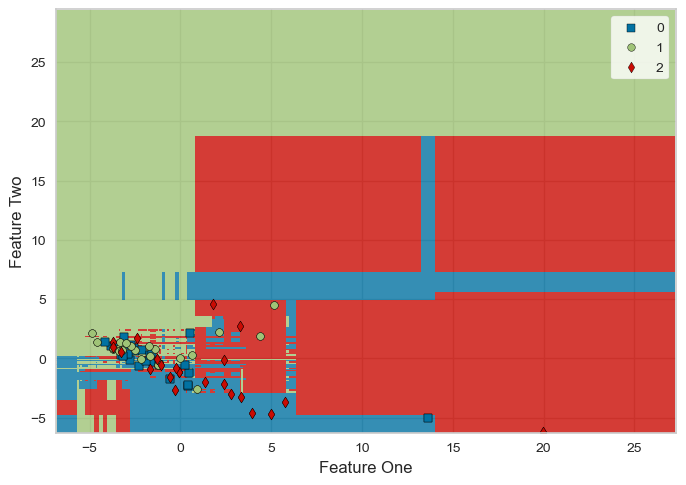

In [48]:
exp.plot_model(best, plot='boundary')

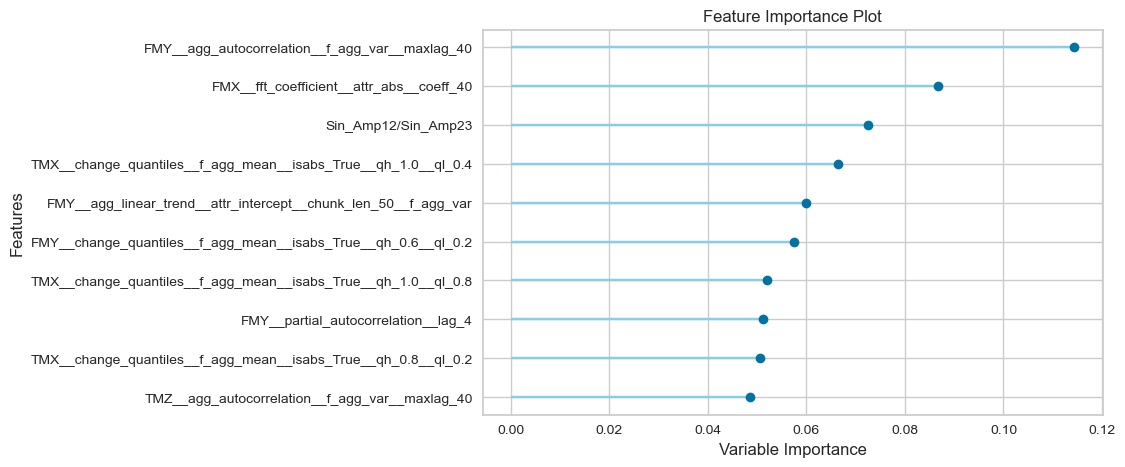

In [44]:
exp.plot_model(best, plot='feature')

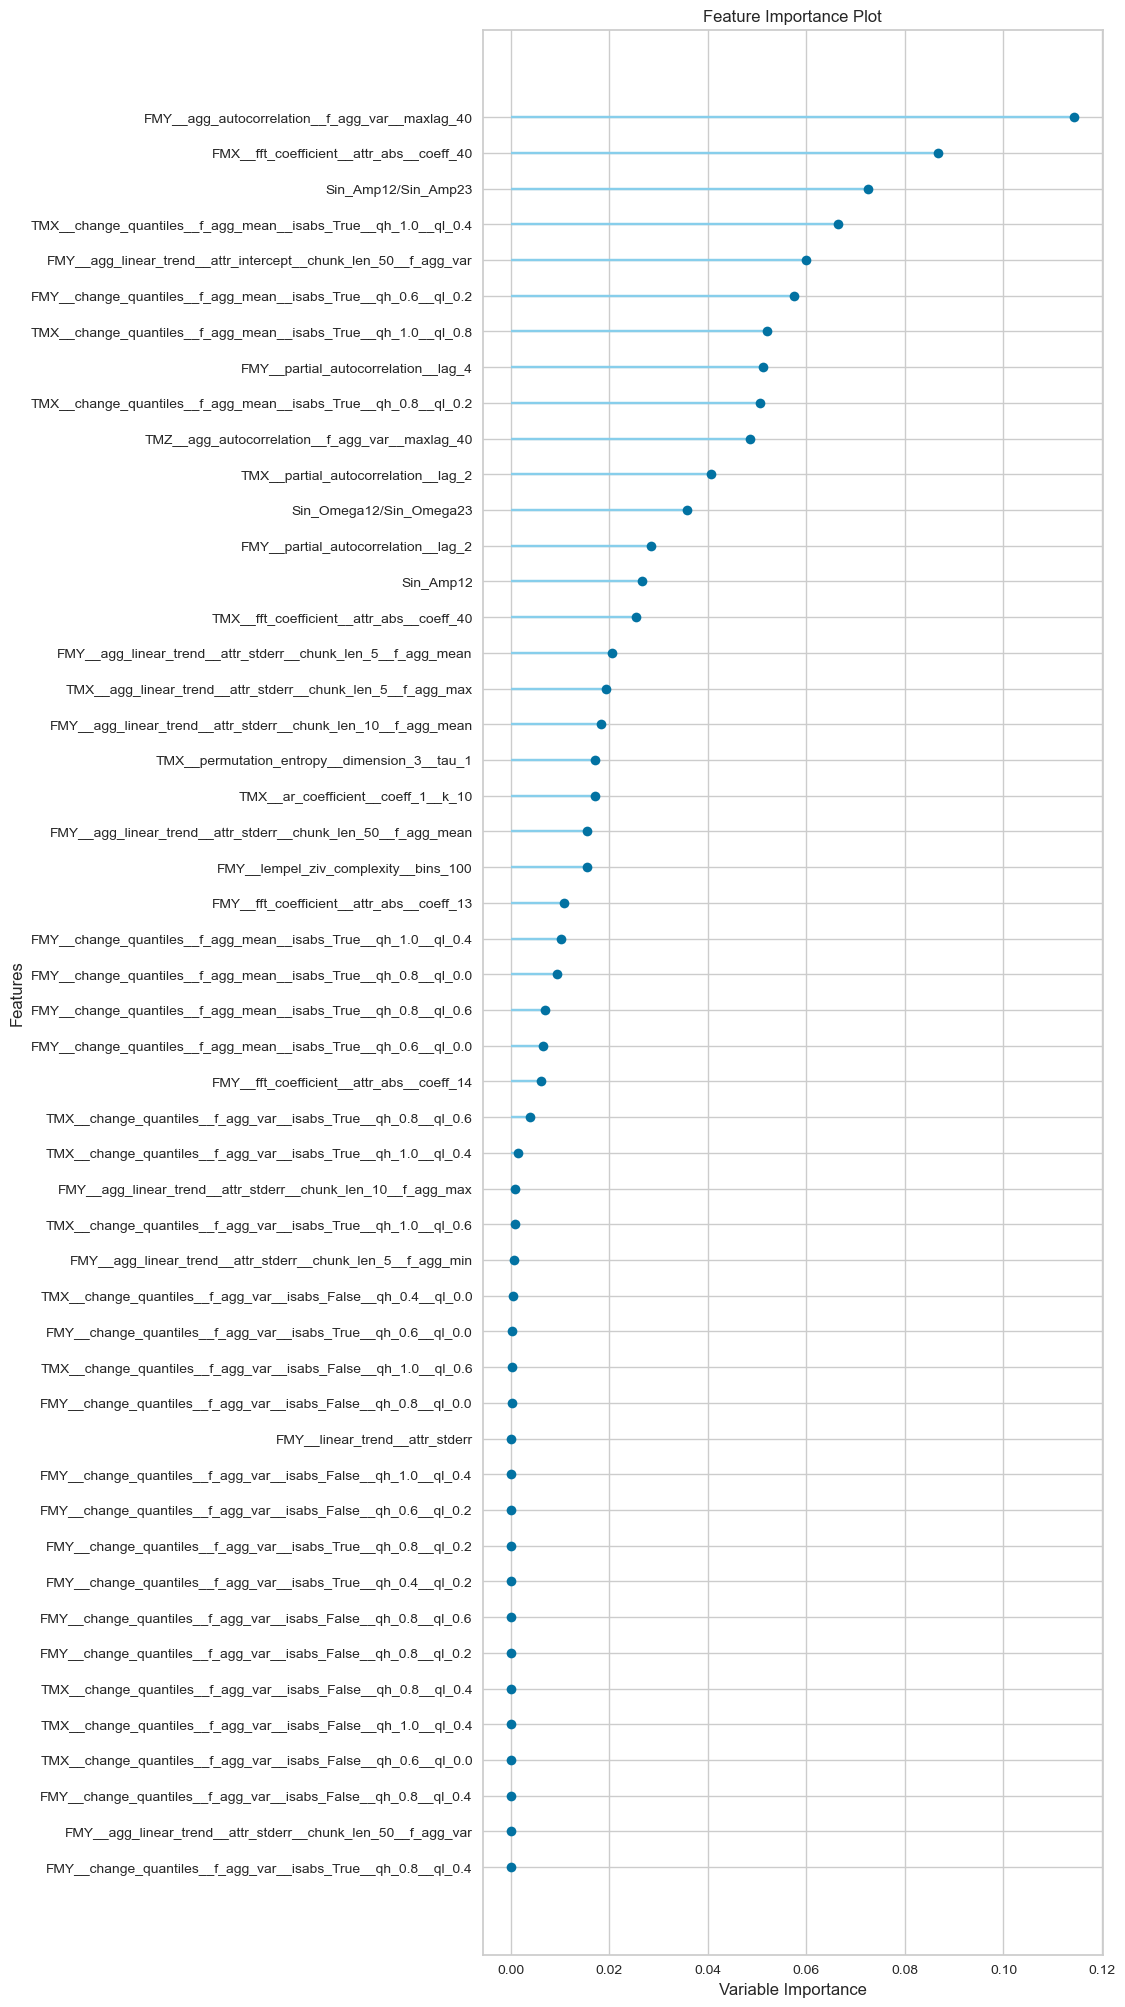

In [51]:
exp.plot_model(best, plot='feature_all')